In [2]:
#%%
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from math import log2




In [3]:
filepath='./Data/'
mushroom = pd.read_csv(filepath+'mushrooms.csv')
# mushroom.head()
mushroom.columns

Index(['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
       'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
       'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
       'stalk-surface-below-ring', 'stalk-color-above-ring',
       'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
       'ring-type', 'spore-print-color', 'population', 'habitat'],
      dtype='object')

In [4]:
# gill_color 및 Target value(=class) 추출
df_gill = mushroom[['gill-color','class']] # 원하는 열이 여러개 일때 []로 감싸줘야한다.

# gill-color별로 edible과 posinous 구분하기
var_gill_color = set(df_gill['gill-color'])
var_class = ['e','p','total','proportion']
instance_total = len(df_gill)

list_gill_class = []
for var in var_gill_color :
    edible = len(df_gill.loc[(df_gill['gill-color'] == var ) & (df_gill['class'] == 'e' )])
    poisonous = len(df_gill.loc[(df_gill['gill-color'] == var ) & (df_gill['class'] == 'p' )])
    total = edible + poisonous
    list_gill_class.append([edible,poisonous, total, round(total/instance_total,3)])

df_gill_class = pd.DataFrame(list_gill_class, index=var_gill_color, columns=var_class)

df_gill_class

,e,p,total,proportion
g,248,504,752,0.093
y,64,22,86,0.011
o,64,0,64,0.008
k,344,64,408,0.050
b,0,1728,1728,0.213
h,204,528,732,0.090
u,444,48,492,0.061
r,0,24,24,0.003
w,956,246,1202,0.148
e,96,0,96,0.012


In [5]:
list_entropy = []
# color 별 entropy 구하기
for var in var_gill_color :
    p = df_gill_class.loc[var]['p']  # color별 class값 불러오기
    e = df_gill_class.loc[var]['e'] # color class 값 불러오기
    total = e+p
    if int(p) == 0 or int(e) == 0 :
        entropy = 0
    else:
        p_p = round(p/total, 2) # p 비율 
        p_e = round(e/total, 2) # e 비율
        # entropy = 'hello'
        entropy = abs(round(p_p*log2(p_p) + p_e*log2(p_e),2))
        # print(entropy)
    list_entropy.append(entropy)

# print(list_entropy)
df_gill_class['entropy'] = list_entropy  # dataframe에 list 넣기(cloumns으로)

# entropy 기준으로 재정렬
sort_entropy_df = df_gill_class.sort_values(by='entropy')

sort_entropy_df
# # 행 범위 설정하기 iloc
# sort_entropy_df = sort_entropy_df.iloc[0:10,:]

,e,p,total,proportion,entropy
o,64,0,64,0.008,0.00
b,0,1728,1728,0.213,0.00
r,0,24,24,0.003,0.00
e,96,0,96,0.012,0.00
u,444,48,492,0.061,0.47
n,936,112,1048,0.129,0.50
k,344,64,408,0.050,0.63
w,956,246,1202,0.148,0.72
y,64,22,86,0.011,0.83
h,204,528,732,0.090,0.86


(0.0, 1.0)

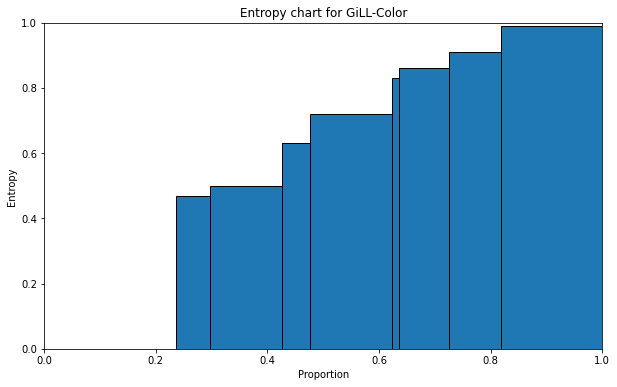

In [6]:
# mariemekko chart 
# 참조 : https://towardsdatascience.com/marimekko-charts-with-pythons-matplotlib-6b9784ae73a1
plt.figure(figsize=(10,6))
proportion = list(sort_entropy_df['proportion']) # Bar 크기
y_axis = list(sort_entropy_df['entropy']) # Y축
x_axis = [0] # bar 별 시작위치 만들기 
for var in proportion[:-1] :
    x = x_axis[-1]+var
    x_axis.append(x)

plt.bar(x_axis, y_axis, label = sort_entropy_df.index, width=proportion, align='edge', edgecolor='black')
plt.title("Entropy chart for GiLL-Color")
plt.rc('font', size=15)
plt.ylabel("Entropy",)
plt.xlabel("Proportion")
plt.ylim(0,1)
plt.xlim(0,1)
# sns.barplot(x=x_axis, y=y_axis, hue = sort_entropy_df.index)
# plt.legend()

In [7]:
# Information Gain

# Parent entropy
parent = list(mushroom['class'])
total = len(parent)
p_e = parent.count('e')/total
p_p = parent.count('p')/total
Parent_entropy = abs(p_e*log2(p_e)+p_p*log2(p_p))

# Children entropy
children_list = sort_entropy_df[['entropy','proportion']].values.tolist() # 대박스...

children_entropy = 0
for a, b in children_list :
    children_entropy += a*b


Information_Gain = Parent_entropy - children_entropy

print(f'Parent_entropy: {round(Parent_entropy,3)}')
print(f'children_entropy: {round(children_entropy,3)}')
print(f'Information_Gain: {round(Information_Gain,3)}')

Parent_entropy: 0.999
children_entropy: 0.585
Information_Gain: 0.415


In [8]:
# Entropy 공식 만들기

# 엔트로피 계산 = 비율 *log2  비율 = 대상/전체 
# 대상 = 특정 기준이 e와 p를 가지고 있는 비중 

# 대상 선정 
# 변수별 개수 확인

def entropy_cal(attr) :
    var_x = list(set(mushroom[attr]))  # 해당 attr variable 추출
    entire_num = len(mushroom) # instance 개수 

    # variable별 entropy 및 비율 계산
    list_entropy = []
    for var in var_x :
        e = len(mushroom.loc[(mushroom[attr] == var ) & (mushroom['class'] == 'e' )])
        p = len(mushroom.loc[(mushroom[attr] == var ) & (mushroom['class'] == 'p' )])
        total = e+p
        p_p = round(p/total,3) # variable 내에서 p의 비율 
        p_e = round(e/total,3) # variable 내에서 e의 비율 
        
        #entropy 계산
        if p_p == 0 or p_e == 0 : # p_p와 p_e에 round 했기에 0이 나올 수 있음
            entropy = 0
        else:
            entropy = abs(round(p_p*log2(p_p) + p_e*log2(p_e),3)) # 변수가 n개이기 때문에 n번 계산
            

        #비율계산 
        proportion = round(total/entire_num,3) # Variable 별 Total / 전체 개수

        # Variable 별로 entropy와 proportion 저장
        list_entropy.append([entropy,proportion]) 

    #데이터 프레임 만든 뒤 entropy를 기준으로 정렬 
    df = pd.DataFrame(list_entropy, index= var_x, columns= ['entropy','proportion'])
    df = df.sort_values(by='entropy') # entropy 작은순으로 정렬

    # 그래프 제작을 위한 비율 누적
    proportion = list(df['proportion'])# 누적 x축 만들기 
    x_axis = [0]
    for var in proportion[:-1] :
        x = x_axis[-1]+var
        x_axis.append(x)

    # x_axis, Dataframe에 추가하기
    df['x_axis'] = x_axis

    return df

# Makko plot 생성 함수
def makko_plot(df, name=None) : 
    plt.figure(figsize=(10,6))
    plt.bar(df['x_axis'], df['entropy'], label = df.index, width=df['proportion'], align='edge', edgecolor='black')
    plt.title(f"Entropy chart for {name}")
    plt.rc('font', size=15) # 그래프 디자인 설정
    plt.ylabel("Entropy",)
    plt.xlabel("Proportion")
    plt.ylim(0,1) # y축 범위 설정
    plt.xlim(0,1) # y축 범위 설정


# Information Gain
def info_gain(df):
    parent = list(mushroom['class'])
    total = len(parent)
    p_e = parent.count('e')/total
    p_p = parent.count('p')/total
    Parent_entropy = abs(p_e*log2(p_e)+p_p*log2(p_p))

    children_list = df[['entropy','proportion']].values.tolist() # 대박스...

    # 엔트로피 계산
    children_entropy = 0
    for a, b in children_list :
        children_entropy += a*b

    info_gain = Parent_entropy - children_entropy

    print(f'Parent_entropy: {round(Parent_entropy,3)}')
    print(f'children_entropy: {round(children_entropy,3)}')
    print(f'Information_Gain: {round(info_gain,3)}')
    return info_gain

Parent_entropy: 0.999
children_entropy: 0.583
Information_Gain: 0.416


0.4155738968724605

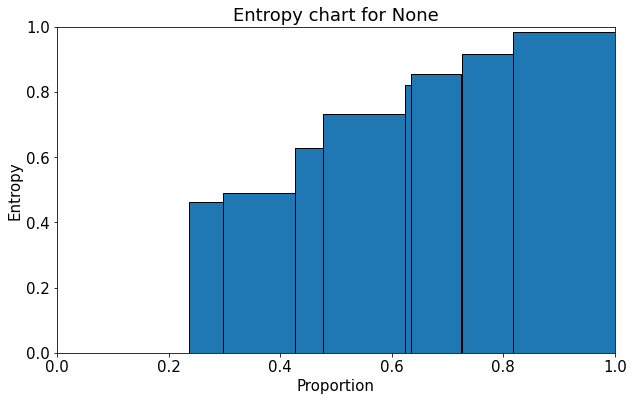

In [9]:
gill = entropy_cal('gill-color')
makko_plot(gill)
info_gain(gill)


Parent_entropy: 0.999
children_entropy: 0.518
Information_Gain: 0.481


0.4811868968724604

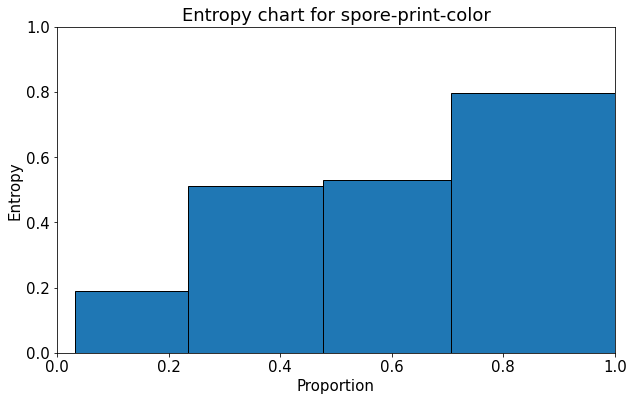

In [10]:
spore = entropy_cal('spore-print-color')
makko_plot(spore, name = 'spore-print-color')
info_gain(spore)

Parent_entropy: 0.999
children_entropy: 0.093
Information_Gain: 0.906


0.9061918968724605

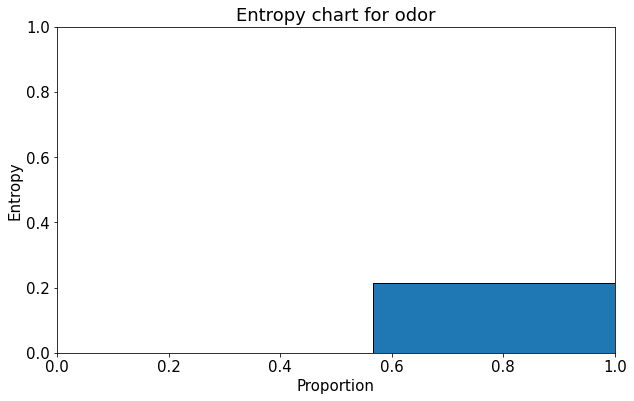

In [11]:
odor = entropy_cal('odor')
makko_plot(odor, name = 'odor')
info_gain(odor)